## The Nugget effect

The nugget effect in kriging is a source of misunderstanding and misinterpretation. In this notebook we therefore present an example of multiple ways to interpret and include a nugget effect in a kriging analysis and specifiy the method used in the GemPy. 
<br>
<br>
In literature the nugget effect is often subdivided into two different phenomena:
<br>
<br>
1) **Microscale variation** (or "True nugget effect"): This describes real geological microscale variations (as in gold nuggets, hence the name). It can be interpreted as a second variogram (meaning a second scale of spatial correlation) with a very small range compared to the general scale of spatial correlation. Therefore it also includes variation below the resolution of the measurements e.g. the closest distance between measurement locations. 
<br>
<br>
2) **Measurement error:** (or "Noise"/"Human nugget effect"). This includes measurement errors occuring from either sampling or assaying. It thus covers a subscale variance that is inherent to the wohle dataset.
<br>
<br>
The big difference between those interpretations lies in how they treat the origin of the variogram. In case of a pure nugget effect, gamma(0) = 0 by definiton. This causes the nested variogram (exponential variogram plus nugget variogram) to be discontinous at the origin. It also ensures that kriging stays an exact interpolator, meaning that if you estiamte at a location where data is available, it will take this exact value.

If we consider the nugget effect to be noise from measurement errors, this means that estimates are allowed to deviate from measurements at same locations (as there might be a measurement error) and kriging stops being an exact interpolator. This generally leads to smoother results.

This example follows:

Krivoruchko, K., A. Gribov, and J. M. Ver Hoef, 2006,
*A new method for handling the nugget effect in
kriging*, in T. C. Coburn, J. M. Yarus, and R. L.
Chambers, eds., Stochastic modeling and geostatistics: Principles, methods, and case studies, vol-
ume II: AAPG Computer Applications in Geology 5,
p. 81–89.

In [2]:
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In the following we define the experimental variogram function used in this example. It is a nested variogram composed of the exponential model and a nugget component. Note that we define the sill passed to the function as the total sill of the nested variogram. The partial sill (basically the sill of the exponential varigoram without the nugget effect) is defined as the total sill minus the nugget component. The range parameter used here is the one directly used in the function. Other applications often provide the so called "practical range" of 3a (exponential variogram) for the spatial correlation scale. For comparison the corresponding covariance function is also included. 

In [3]:
def exponential_variogram_model(d, range_, sill, nugget):
    psill = sill - nugget
    gamma = psill * (1. - np.exp(-(np.absolute(d) / (range_)))) + nugget

    return gamma

def exponential_covariance_model(d, range_, sill, nugget):
    psill = sill - nugget
    cov = psill * (np.exp(-(np.absolute(d) / (range_))))
    
    return cov

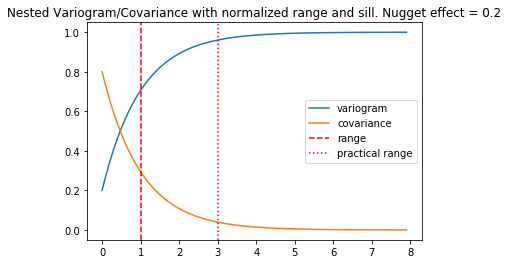

In [11]:
d = np.arange(0,8,0.1)
vario_plot = exponential_variogram_model(d, range_=1, sill=1, nugget=0.2)
cov_plot = exponential_covariance_model(d, range_=1, sill=1,nugget=0.2)

plt.plot(d, vario_plot, label='variogram')
plt.plot(d, cov_plot, label='covariance')
plt.axvline(x=1,color='red', linestyle='--', label='range')
plt.axvline(x=3,color='red', linestyle=':', label='practical range' )
plt.title('Nested Variogram/Covariance with normalized range and sill. Nugget effect = 0.2')
plt.legend()

The following cells contain the relevant Kriging functions. They are basically copied from the gempy module assets.kriging, only slightly changed to display the 1D case and the different versions of the nugget effect.

In [28]:
def kriging_1D(krig_locs, data, range_, sill, nugget, nugget_type='pure'): 
    # empty arrays for results (estimated values and variances)
    kriging_result_vals = np.zeros(len(krig_locs))
    kriging_result_vars = np.zeros(len(krig_locs))
    
    # calculate distances between all input data points
    dist_all_to_all = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        dist_all_to_all[:,i] = np.absolute(data[:, 0]-data[i, 0])
    
    dist_grid_to_all = np.zeros((len(krig_locs), len(data)))
    for i in range(len(krig_locs)):
        dist_grid_to_all[i,:] = np.absolute(data[:, 0]-krig_locs[i])
    # calculate distances between all grid points and all input data point)
                                            
    # Main loop that goes through whole domain (grid)
    for i in range(len(krig_locs)):

        # STEP 1: Multiple if elif conditions to define moving neighbourhood:
        a = dist_grid_to_all[i]
        b = dist_all_to_all
        prop = data[:, 1]
        # STEP 2: Multiple if elif conditions to calculate kriging at point
        val, var = ordinary_kriging(a, b, prop,range_, sill,nugget, nugget_effect=nugget_type)
        # STEP 3: Save results
        kriging_result_vals[i] = val
        kriging_result_vars[i] = var
        # create dataframe of results data for calling
        d = {'X_loc': krig_locs, 'est_value': kriging_result_vals, 'est_variance': kriging_result_vars}
        results_df = pd.DataFrame(data=d)
        
    return results_df
    
def ordinary_kriging(b, a, prop, range_, sill, nugget, nugget_effect):
        # empty matrix building for OK
        shape = len(a)
        C = np.zeros((shape + 1, shape + 1))
        c = np.zeros((shape + 1))
        w = np.zeros((shape + 1))
        # filling matirces based on model for spatial correlation
        
        C[:shape, :shape] = exponential_variogram_model(a,range_,sill,nugget)
        c[:shape] = exponential_variogram_model(b,range_,sill,nugget)
        
        np.fill_diagonal(C, 0)
        
        if nugget_effect == 'exact':
            c[c==nugget]=0
        
        # matrix setup - compare pykrige, special for OK
        C[shape, :] = 1.0
        C[:, shape] = 1.0
        C[shape, shape] = 0.0
        c[shape] = 1.0
    
        w = np.linalg.solve(C, c)
    
        # calculating estimate and variance for kriging, variance is weird
        pred_var = w[shape] + np.sum(w[:shape] * c[:shape])
        
        if nugget_effect == 'filtered':
            pred_var = pred_var-nugget
        
        #result = np.sum(w[:shape] * prop)
        result = np.dot(prop, w[:shape])
        
        return result, pred_var

### Example

In the following cells a simple example from given literature (Krivoruchko, K., A. Gribov, and J. M. Ver Hoef, 2006) is reproduced to highlight the effect of different interpretations of the nugget effect.

Three interpretations are implemented:
<br>
<br>
1) **Exact**: The pure nugget effect. Discontinuous origin of variogram. Kriging is exact interploator. Estimates at data locations are equal to measured value. Standard deviation at these locations is zero.
<br>
<br>
2) **Filtered**: Prediction with noise removed. In this example the nugget effect is assumed to be only noise (measurement error). A filtered prediction thus is not exact anymore and reduces the standard deviation as the measurement error is filtered out.
<br>
<br>
3) **New Value**: Estiamtes new value at data locations similar to filtered version. Standard deviation at data locations though foloows exact version.

In the provided kriging module for gempy, *New Value Kriging* is used when a nugget component is included, to provide smooth results on the kriged grids and reduce the effect of coinciding grid and data locations, while obtaining a reasonable value for standard deviation, which is also important when creating Gaussian fields.

In [37]:
# Simple 1D example with two locations and data values at these locations
locs = np.arange(0,3,0.1)
inp = np.array([[1,-1],[2,1]])

In [38]:
# Fucntion to compare all three solutions
def compare(range_, sill, nugget):
    
    results_df1 = kriging_1D(locs, inp, range_=range_, sill=sill, nugget=nugget, nugget_type='exact')
    loc1 = results_df1['X_loc'].values
    val1 = results_df1['est_value'].values
    var1 = results_df1['est_variance']
    
    results_df2 = kriging_1D(locs, inp, range_=range_, sill=sill, nugget=nugget, nugget_type='new_value')
    loc2 = results_df2['X_loc'].values
    val2 = results_df2['est_value'].values
    var2 = results_df2['est_variance']
    
    results_df3 = kriging_1D(locs, inp, range_=range_, sill=sill, nugget=nugget, nugget_type='filtered')
    loc3 = results_df3['X_loc'].values
    val3 = results_df3['est_value'].values
    var3 = results_df3['est_variance']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    
    axes[0].plot(inp[:,0], inp[:,1], 's', markersize=10, fillstyle='none', color='black', label='data value')
    axes[0].plot(loc1, val1, '-o', label='exact')
    axes[0].plot(loc2, val2, '-o', markersize=3, label='new value/filtered')
    axes[0].set_ylim(-1.5,1.5)
    axes[0].legend()
    
    axes[1].set_ylim(0,1.5)
    axes[1].plot(loc1, np.sqrt(np.round(var1,2)))
    axes[1].plot(loc2, np.sqrt(var2))
    axes[1].plot(loc3, np.sqrt(var3)) 
 

In [39]:
interact(compare, range_=(1,11,1), sill=(0.5,1.5,0.1), nugget=(0,1,0.1));

interactive(children=(IntSlider(value=6, description='range_', max=11, min=1), FloatSlider(value=1.0, descript…